In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
torch.cuda.is_available()

True

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
def load_data(L,temp,MCS):
    return np.fromfile(f"../ising_wolff/dataIsing2D_L{L}/config_L{L}_T{temp:.3f}.bin",dtype = np.int32).reshape(MCS,L**2)
#def load_data(L,temp,MCS):
#    return np.fromfile(f"/content/drive/MyDrive/ising_data/dataIsing2D_L10/config_L{L}_T{temp:.3f}.bin",dtype = np.int32).reshape(MCS,L**2)

(array([ 3346., 17639., 25617., 26935., 27222., 27339., 27097., 25135.,
        16811.,  2859.]),
 array([-0.96938776, -0.7744898 , -0.57959184, -0.38469388, -0.18979592,
         0.00510204,  0.2       ,  0.39489796,  0.58979592,  0.78469388,
         0.97959184]),
 <BarContainer object of 10 artists>)

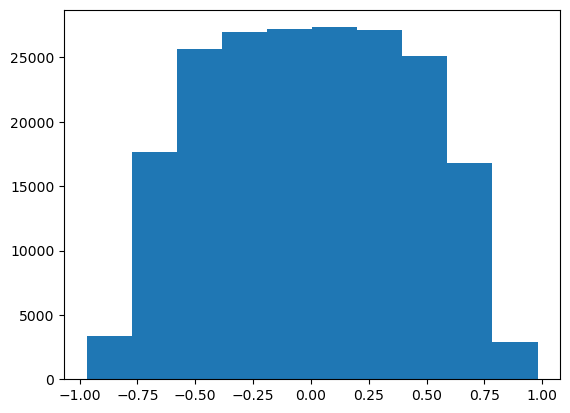

In [4]:
Tmin = 2.27
Tmax = 3.22
meas = 20
Ts = np.linspace(Tmin,Tmax,meas)
L = 14
#data = load_data(L,Ts[9],200000)
data = load_data(L,Ts[6],200000)
Ts[6]
plt.hist(np.mean(data,axis = 1))

$\mathbf{A} = \mathbf{W} + g\left[\mathbf{M}\mathbf{W}-\mathbf{1} \right]$


$\mathbf{W} = \left(\Delta_t \mathbf{1} + \mathbf{C}^0 e^{-2t}\right)^{-1}$

$\mathbf{M} = 3\Delta_t(\Delta_t + e^{-2t} ) \mathbf{1} +(3\Delta_t+e^{-2t})\mathbf{C}^0 e^{-2t} $

The equation for $g$ is:

$\text{Tr}(\mathbf{A}(\mathbf{M}-\mathbf{W}^{-1})) - g \cdot\text{Tr}(x_i^2  (x_i^2-1)^2) + \cdots$ = 0

Let's get the matrix M and W

In [5]:
N =L**2
nSteps =600
dt = 0.01
diffTemp = np.linspace(0.01,1,nSteps)
def Deltat(n,dt,diffTemp):
    return diffTemp*(1-np.exp(-2*(n+1)*dt))

In [6]:
C0 = np.cov(data.T)
W = np.empty((nSteps,N,N))
invW = np.empty((nSteps,N,N))
M = np.empty((nSteps,N,N))
K = np.empty((nSteps,N,N))

In [7]:
for t in range(nSteps):
    Dt = Deltat(t,dt,diffTemp[t])
    exp2t=np.exp(-2*(t+1)*dt)
    invW[t] = Dt*np.eye(N) + C0*exp2t
    W[t] = np.linalg.inv(invW[t])
    M[t] = (3*Dt+exp2t)*C0*exp2t+ 3*Dt*(Dt + exp2t)*np.eye(N)

$\mathbf{A}(\mathbf{M}-\mathbf{W}^{-1}) = \mathbf{W}\mathbf{M} - \mathbf{1} + g\cdot (-2\mathbf{M} + \mathbf{W}^{-1} + \mathbf{M}\mathbf{W}\mathbf{M}) = \mathbf{K} + g\cdot \mathbf{K_g}$

$ \mathbf{K} + g\cdot \mathbf{K_g} - g\cdot \mathbf{C}_6  - \mathbf{C_4} = 0$

In [8]:
K = np.matmul(W,M) - np.eye(W.shape[1])
K_g = -2*M + invW + np.matmul(M,np.matmul(W,M))

Now the other terms

In [9]:
ts= np.array([*range(nSteps)])
Dts = Deltat(ts,dt,diffTemp)
expts = np.exp(-2*(ts+1)*dt)
C6 = Dts*(15*Dts**2 - 6*Dts + 1) + expts *(45*Dts**2 - 12*Dts + 1) + expts**2 * (15*Dts-2) + expts**3
C4 = 3*(Dts+expts)-1

$g = -\frac{\text{Tr}(\mathbf{K}) - \mathbf{C}_4}{\text{Tr}(\mathbf{K}_g) - \mathbf{C}_6}$

In [10]:
num = np.trace(K,axis1=1,axis2=2) - N*C4
den = np.trace(K_g,axis1=1,axis2=2) - N*C6
g = -num/den

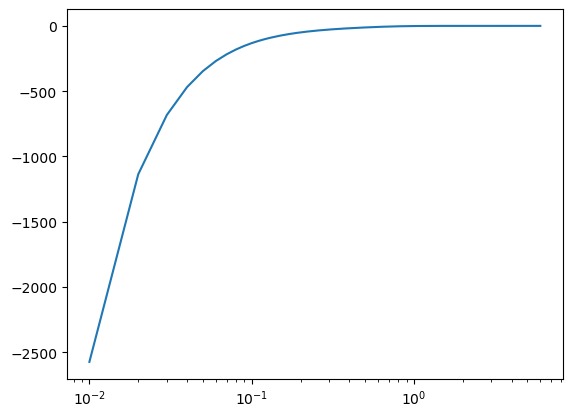

In [11]:
plt.plot((ts+1)*dt,g)
#plt.yscale("log")
plt.xscale("log")
#plt.axvline(dt*2)

$\mathbf{A} = \mathbf{W} + g\left[\mathbf{M}\mathbf{W}-\mathbf{1} \right]$


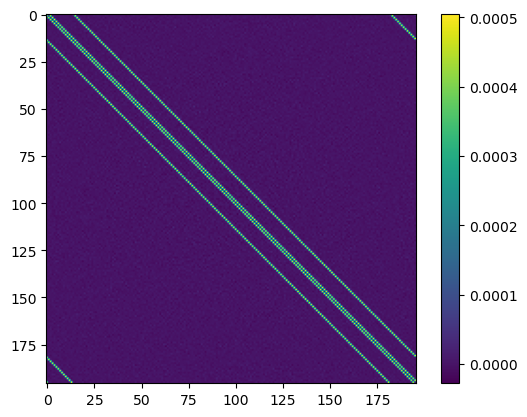

In [12]:
#MW = g.reshape(nSteps,1,1)*(np.matmul(M,W)-np.eye(N).reshape(1,N,N))
A =  W + g.reshape(nSteps,1,1)*(np.matmul(M,W)-np.eye(N).reshape(1,N,N))
#A = W
#plt.imshow(MW[0]-np.diag(np.diag(MW[0])))
plt.imshow(-A[0]+np.diag(np.diag(A[0])))
plt.colorbar()

In [13]:
def myscore(x,A,g,device = "cuda"):
    return  -torch.matmul(x,A.T) + g*x*(x**2-1)

In [19]:
def backward(xT,A,g,temp,nSteps,dt,full_traj = False,every = 5,device = "cuda"):
    P = xT.shape[0]
    N = xT.shape[1]
    A =torch.from_numpy(A).to(device).to(torch.float32)
    g =torch.from_numpy(g).to(device).to(torch.float32)
    nbatches = 50
    batch_size = int(P/nbatches)
    tts = np.linspace(1,nSteps,nSteps-1,dtype = np.int32)
    if(full_traj):
        redSteps = int(nSteps/every)
        tslice = np.linspace(1,nSteps+1,redSteps,dtype = np.int32)
        x_recon = torch.Tensor(P,redSteps,N).to(device)
        x_now =xT.to(device)
    else:
        x_recon = xT.to(device)
    with torch.no_grad():
        for tt in tts[::-1]:
            std = np.sqrt(2*temp[tt-1]*dt)*torch.randn_like(xT).to(device)
            #if tt==1:
            #    std = torch.zeros(xT.shape)

            for n in range(nbatches):
                if(full_traj):
                    score = myscore(x_now[n*batch_size:(n+1)*batch_size,:], A[tt-1],g[tt-1],device)
                    x_now[n*batch_size:(n+1)*batch_size,:] = x_now[n*batch_size:(n+1)*batch_size,:]*(1+dt) + 2*temp[tt-1]*score*dt + std[n*batch_size:(n+1)*batch_size]
                    if(tt in tslice):
                        x_recon[n*batch_size:(n+1)*batch_size,np.where(tslice==tt)[0][0],:]=x_now[n*batch_size:(n+1)*batch_size,:]
                else:
                    score = myscore(x_recon[n*batch_size:(n+1)*batch_size], A[tt-1],g[tt-1],device)
                    x_recon[n*batch_size:(n+1)*batch_size] = x_recon[n*batch_size:(n+1)*batch_size]*(1+dt)+ 2*temp[tt-1]*score*dt + std[n*batch_size:(n+1)*batch_size]
                del score
    
    return x_recon.to("cpu").numpy()

In [20]:
P = 100000
N = L**2
xT = np.sqrt(1)*torch.randn((P,N))
x_recon = backward(xT,A,g,diffTemp,nSteps,dt,full_traj=False,device= "cuda")

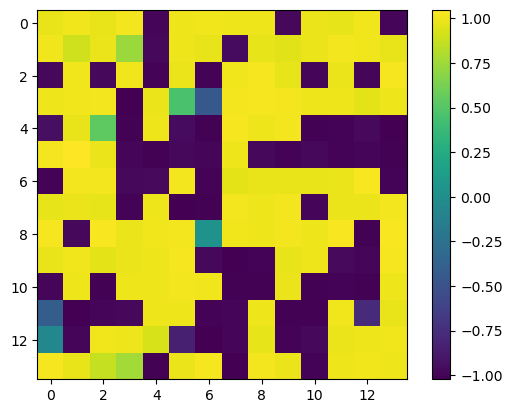

In [21]:
plt.imshow(x_recon[0].reshape(L,L))
plt.colorbar()
#plt.scatter([*range(L)],x_recon[3].reshape(L,L)[6])

In [17]:

Ts[10]
print(skew(np.mean(x_recon,axis = 1)))
print(kurtosis(np.mean(x_recon,axis = 1)))
print(kurtosis(np.mean(data,axis = 1)))

NameError: name 'skew' is not defined

(array([0.08583979, 0.45251885, 0.65719005, 0.69100262, 0.69836545,
        0.70136702, 0.69515864, 0.64482461, 0.43127696, 0.07334607]),
 array([-0.96938776, -0.7744898 , -0.57959184, -0.38469388, -0.18979592,
         0.00510204,  0.2       ,  0.39489796,  0.58979592,  0.78469388,
         0.97959184]),
 <BarContainer object of 10 artists>)

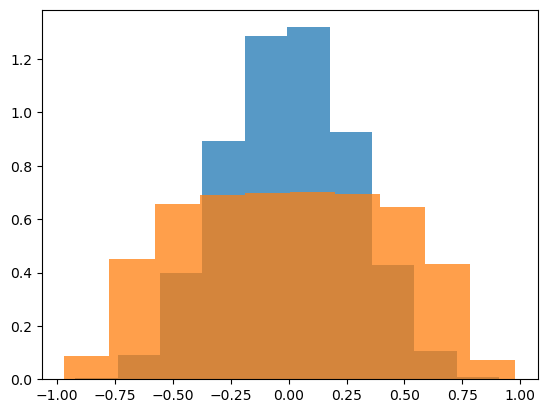

In [22]:
plt.hist(np.mean(x_recon,axis = 1),density=True,alpha = 0.75)
plt.hist(np.mean(data,axis = 1),density=True,alpha = 0.75)

(array([0.        , 3.72662328, 0.32173752, 0.0756875 , 0.0546875 ,
        0.0406875 , 0.03596249, 0.0314125 , 0.0294    , 0.0247625 ,
        0.0291375 , 0.026075  , 0.027825  , 0.0294875 , 0.03421249,
        0.0356125 , 0.047775  , 0.0809375 , 0.33136252, 3.76661076,
        0.        ]),
 array([-1.20000005, -1.08571434, -0.97142857, -0.85714287, -0.74285716,
        -0.62857145, -0.51428574, -0.40000001, -0.2857143 , -0.17142858,
        -0.05714286,  0.05714286,  0.17142858,  0.2857143 ,  0.40000001,
         0.51428574,  0.62857145,  0.74285716,  0.85714287,  0.97142857,
         1.08571434,  1.20000005]),
 <BarContainer object of 21 artists>)

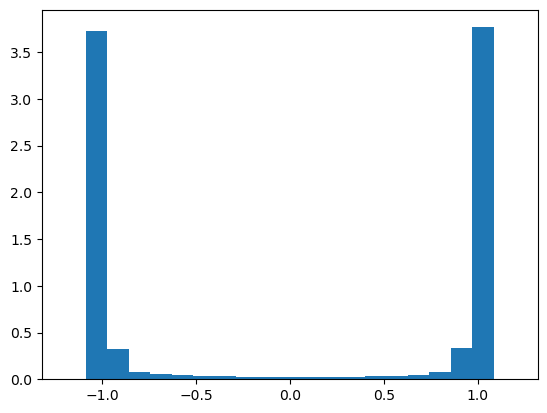

In [23]:
plt.hist(x_recon[:,2],range=(-1.2,1.2),bins = 21,density=True)

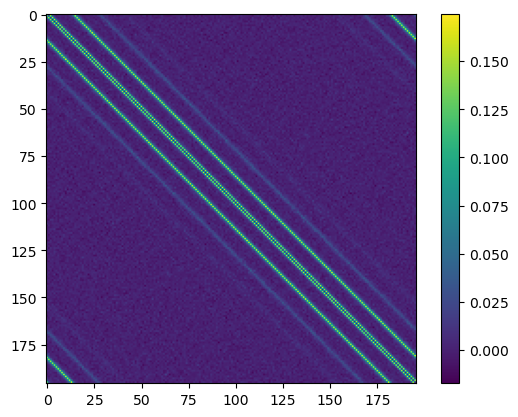

In [24]:
Jrecon = np.linalg.inv(np.cov(x_recon.T))
Jrecon = -Jrecon +np.diag(np.diag(Jrecon))
plt.imshow(Jrecon)
plt.colorbar()

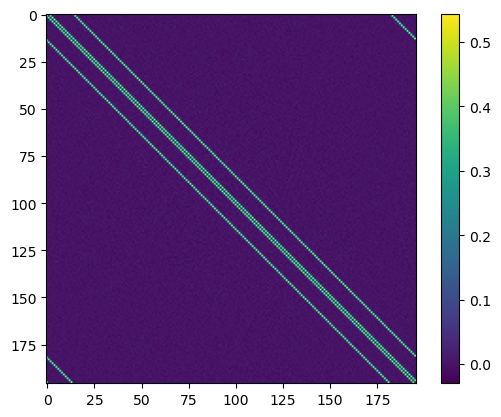

In [203]:
Jtrue = np.linalg.inv(np.cov(data.T))
#Jtrue = (np.cov(data.T))
Jtrue = -Jtrue +np.diag(np.diag(Jtrue))
plt.imshow(Jtrue)
plt.colorbar()

In [124]:
def getScoreParams(x0,diffTemp,dt,nSteps):
    N = x0.shape[1]
    C0 = np.cov(x0.T)
    W = np.empty((nSteps,N,N))
    invW = np.empty((nSteps,N,N))
    M = np.empty((nSteps,N,N))
    K = np.empty((nSteps,N,N))
    ts= np.array([*range(nSteps)])
    Dts = Deltat(ts,dt,diffTemp)
    exp2ts = np.exp(-2*(ts+1)*dt)

    for t in range(nSteps):
        invW[t] = Dts[t]*np.eye(N) + C0*exp2ts[t]
        W[t] = np.linalg.inv(invW[t])
        M[t] = (3*Dts[t]+exp2ts[t])*C0*exp2ts[t]+ 3*Dt[t]*(Dt[t] + exp2ts[t])*np.eye(N)
    
    K = np.matmul(W,M) - np.eye(W.shape[1])
    K_g = -2*M + invW + np.matmul(M,np.matmul(W,M))

    C6 = Dts*(15*Dts**2 - 6*Dts + 1) + expts *(45*Dts**2 - 12*Dts + 1) + expts**2 * (15*Dts-2) + expts**3
    C4 = 3*(Dts+expts)-1
    num = np.trace(K,axis1=1,axis2=2) - N*C4
    den = np.trace(K_g,axis1=1,axis2=2) - N*C6

    g = -num/den
    A =  W + g.reshape(nSteps,1,1)*(np.matmul(M,W)-np.eye(N).reshape(1,N,N))

    return A,g

In [148]:
def gen_noisy_data(x0,step,temp,dt,device = "cpu"):
    x0 = torch.from_numpy(x0).to(torch.float32)
    x0 = x0.to(device)
    step = step.to(device)
    noise = torch.randn_like(x0).to(device)
    exp_t =torch.exp(-dt*(step+1)).view(-1, 1)
    std_t = torch.sqrt(temp*(1-exp_t*exp_t))
    noisy_data = x0*exp_t + noise*std_t
    return noisy_data, -noise/std_t
noisy = torch.Tensor(50000,nSteps+1,N)
for t in ts:
    tt = torch.Tensor([[t,]]).to(torch.float32)
    noisy[:,t,:], tmp = gen_noisy_data(data[:50000],tt,diffTemp,dt)
#C4_true = np.mean(noisy**2*(noisy**2-1)**2,axis = 1)
#plt.plot(ts*dt,C4)

In [149]:
noisy = noisy.numpy()

In [150]:
M_true = np.zeros((nSteps+1,N,N))
for t in range(nSteps+1):
    M_true[t] = np.matmul((noisy[:,t,:].T)**3,noisy[:,t,:])/50000  - np.mean(noisy[:,t,:]**3,axis = 0)*np.mean(noisy[:,t,:],axis = 0)